# **Decision Tree**

## **🔸 Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from graphviz import Digraph

## **🔸 ID3 (from Scratch)**

### Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1zjjYSr3qXYZg2_vykwhmjBF6NOUmI3jl
# https://drive.google.com/file/d/1zjjYSr3qXYZg2_vykwhmjBF6NOUmI3jl/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1zjjYSr3qXYZg2_vykwhmjBF6NOUmI3jl
To: /content/covid.csv
100% 258/258 [00:00<00:00, 876kB/s]


In [ ]:
data = pd.read_csv('/content/covid.csv')
data

,Fever,Cough,Breathing issues,Infected
0,No,No,No,No
1,Yes,Yes,Yes,Yes
2,Yes,Yes,No,No
3,Yes,No,Yes,Yes
4,Yes,Yes,Yes,Yes
5,No,Yes,No,No
6,Yes,No,Yes,Yes
7,Yes,No,Yes,Yes
8,No,Yes,Yes,Yes
9,Yes,Yes,No,Yes


### Model

\begin{align}
\text{Entropy}(Y) = -\sum_{i=1}^{C} p_i \log_2(p_i)
\end{align}

In [ ]:
labels = data['Infected']
len(labels), labels.unique(), labels.value_counts()
p = labels.value_counts() / len(labels)
-sum(p * np.log2(p))

0.9852281360342515

In [ ]:
def entropy(labels):
    p = labels.value_counts() / len(labels)
    return -sum(p * np.log2(p))

data['Infected'].value_counts()

Yes    8
No     6
Name: Infected, dtype: int64

In [ ]:
 entropy_child = 0
 for value in data['Cough'].unique():
        subset = data[data['Cough'] == value]
        print(subset)
        wi = len(subset) / len(data)
        entropy_child += wi * entropy(subset['Infected'])
entropy_child

  Fever Cough Breathing issues Infected
0    No    No               No       No
3   Yes    No              Yes      Yes
6   Yes    No              Yes      Yes
7   Yes    No              Yes      Yes
   Fever Cough Breathing issues Infected
1    Yes   Yes              Yes      Yes
2    Yes   Yes               No       No
4    Yes   Yes              Yes      Yes
5     No   Yes               No       No
8     No   Yes              Yes      Yes
9    Yes   Yes               No      Yes
10    No   Yes               No       No
11    No   Yes              Yes      Yes
12    No   Yes              Yes       No
13   Yes   Yes               No       No


0.9460794641311808

In [ ]:
entropy(data['Infected'])

0.9852281360342515

#### * Information Gain

\begin{align}
\text{Information Gain}(\text{Feature}) = \text{Entropy}(\text{Parent}) - \sum_{\text{value} \in \text{Feature}} \frac{|\text{Subset with value}|}{|\text{Parent}|} \times \text{Entropy}(\text{Subset with value})
\end{align}

In [ ]:
target = 'Infected'
entropy_parent = entropy(data[target])
entropy_parent

entropy_child = 0
feature = 'Fever'
for value in data[feature].unique():
    subset = data[data[feature] == value]
    display(subset)
    wi = len(subset) / len(data)
    entropy_child += wi * entropy(subset[target])
information_gain = entropy_parent - entropy_child

print(information_gain)

,Fever,Cough,Breathing issues,Infected
0,No,No,No,No
5,No,Yes,No,No
8,No,Yes,Yes,Yes
10,No,Yes,No,No
11,No,Yes,Yes,Yes
12,No,Yes,Yes,No


,Fever,Cough,Breathing issues,Infected
1,Yes,Yes,Yes,Yes
2,Yes,Yes,No,No
3,Yes,No,Yes,Yes
4,Yes,Yes,Yes,Yes
6,Yes,No,Yes,Yes
7,Yes,No,Yes,Yes
9,Yes,Yes,No,Yes
13,Yes,Yes,No,No


0.12808527889139443


In [ ]:
def information_gain(data, feature, target):
    # Entropy of parent
    entropy_parent = entropy(data[target])

    # Entropy of child
    entropy_child = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        #display(subset)
        wi = len(subset) / len(data)
        entropy_child += wi * entropy(subset[target])

    return entropy_parent - entropy_child

arg=[information_gain(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns]

In [ ]:
np.argmax(arg)

2

In [ ]:
def information_gain(data, feature, target):
    # Entropy of parent
    entropy_parent = entropy(data[target])

    # Entropy of child
    entropy_child = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        wi = len(subset) / len(data)
        entropy_child += wi * entropy(subset[target])

    return entropy_parent - entropy_child

In [ ]:
information_gain(data, 'Fever', 'Infected')

0.12808527889139443

In [ ]:
information_gain(data, 'Cough', 'Infected')

0.0391486719030707

In [ ]:
information_gain(data, 'Breathing issues', 'Infected')

0.39603884492804464

In [ ]:
data.iloc[:, :-1].columns

Index(['Fever', 'Cough', 'Breathing issues'], dtype='object')

In [ ]:
[information_gain(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns]

[0.12808527889139443, 0.0391486719030707, 0.39603884492804464]

In [ ]:
np.argmax([information_gain(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns])

2

In [ ]:
class Node:
  def __init__(self, feature=None, label=None):
    self.feature = feature
    self.label = label
    self.children = {}
  def __repr__(self):
    if self.feature is not None:
      return f'DecisionNode(feature="{self.feature}", children={self.children})'
    else:
      return f'LeafNode(label="{self.label}")'


In [29]:
def make_tree(data, target):
  # leaf node?
  if len(data[target].unique()) == 1:
    return Node(label=data[target].iloc[0])
  features = data.drop(target, axis=1).columns
  if len(features) == 0 or len(data) == 0:
    return Node(label=data[target].mode()[0])
  # calculate information gain
  gains = [information_gain(data, feature, target) for feature in features]
  # greedy search to find best fearure
  max_gains_idx = np.argmax(gains)
  best_features = features[max_gains_idx]
  # make a node
  node = Node(feature=best_features)
  # loop over the best feature
  for value in data[best_features].unique():
    subset = data[data[best_features] == value].drop(best_features, axis=1)
    # display(subset)
    node.children[value] = make_tree(subset, target)
  return node

In [ ]:
tree = make_tree(data, 'Infected')
tree

DecisionNode(feature="Breathing issues", children={'No': DecisionNode(feature="Fever", children={'No': LeafNode(label="No"), 'Yes': DecisionNode(feature="Cough", children={'Yes': LeafNode(label="No")})}), 'Yes': DecisionNode(feature="Fever", children={'Yes': LeafNode(label="Yes"), 'No': DecisionNode(feature="Cough", children={'Yes': LeafNode(label="Yes")})})})

In [ ]:
tree.feature

'Breathing issues'

### Visualization

In [ ]:
def visualize_tree(tree, parent=None, node_id=None):
    if node_id is None:
        node_id = '0'
        g = Digraph(node_attr={'shape': 'record', 'height':'.1'})
        g.node(node_id, label=tree.feature)
    else:
        g = parent
        g.node(node_id, label=tree.feature)
    if len(tree.children) == 0:
        g.node(node_id, label=tree.label)
        return g
    for i, (value, child) in enumerate(tree.children.items()):
        child_id = f'{node_id}_{i+1}'
        visualize_tree(child, g, child_id)
        g.edge(node_id, child_id, label=value)
    return g
g = visualize_tree(tree)
g.render('decision_tree', format='png', view=True)

'decision_tree.png'

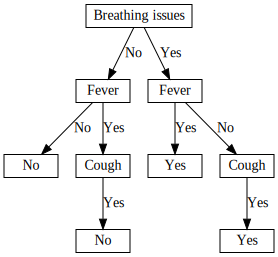

In [ ]:
visualize_tree(tree)